In [30]:
import pickle
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn

from utils import collect_trajectories, train, \
                  ReplayBuffer, LinearEpsilon
from env import Environment
from agent import DQNAgent

## Load env

In [31]:
with open('configs/extra_simple_field_config.pkl', 'rb') as file:
    config = pickle.load(file)
    
env = Environment(config, add_agent_value=True)

## Train

In [32]:
coord_range = np.prod(env.field.shape)
field_values_range = 6
coord_emb_dim = 4
field_emb_dim = 2

In [33]:
device = torch.device('cuda')

agent = DQNAgent(coord_range, field_values_range, coord_emb_dim, field_emb_dim).to(device)
opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

target_network = DQNAgent(coord_range, field_values_range, coord_emb_dim, field_emb_dim).to(device)
_ = target_network.load_state_dict(agent.state_dict())

In [34]:
n_epochs = 5 * 10**3

eps = LinearEpsilon(2 * 10**3, min_value=0.01, max_value=1)

trajs_per_epoch = 1
batch_size = 16

refresh_target_network_freq = 20
loss_log_freq = 20
plot_every = 50

In [35]:
exp_replay = ReplayBuffer(2 * 10**2)
collect_trajectories(2 * 10**2, agent, env, exp_replay)
print(len(exp_replay))

200


### Markov assumption satisfied

Epoch #5000


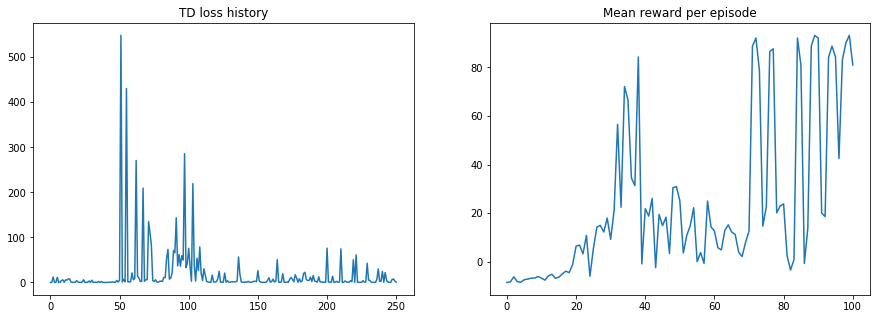

In [36]:
train(n_epochs, env, agent, 
      target_network, opt, exp_replay, eps, 
      trajs_per_epoch, batch_size, device, 
      refresh_target_network_freq, loss_log_freq, plot_every)

### Markov assumption not satisfied

Epoch #5000


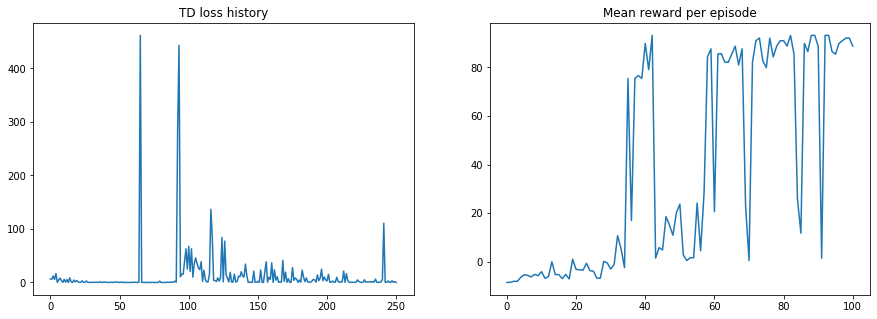

In [16]:
train(n_epochs, env, agent, 
      target_network, opt, exp_replay, eps, 
      trajs_per_epoch, batch_size, device, 
      refresh_target_network_freq, loss_log_freq, plot_every)

### Evaluate

101


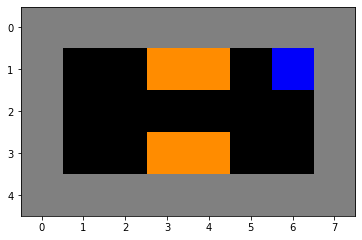

In [23]:
from matplotlib import pyplot as plt
from celluloid import Camera

def animate_agent(env, agent, filename='agent.gif', max_steps=100):
    agent.epsilon = 0
    
    fig = plt.figure()
    camera = Camera(fig)
    
    s = env.reset()
    n_steps = 0
    total_reward = 0
    done = False
    env.render()
    camera.snap()
    while (not done and n_steps < max_steps):
        qvalues = agent.get_qvalues(s)
        a = agent.sample_actions(qvalues).item()
        next_s, r, done = env.step(a)
        total_reward += r
        env.render()
        camera.snap()
        s = next_s
        n_steps += 1
    animation = camera.animate()
    animation.save(filename, writer='imagemagick')
    print(total_reward)

animate_agent(env, agent, 'render.gif')